In [1]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('../../')

import matplotlib.pyplot as plt
import numpy as np
import Phys
# physical constants in cgs units
constants = Phys.ReadPhys()
import importlib
from SpecWizard_Input import ReadData

import SpecWizard_BuildInput
SpecWizard_BuildInput = importlib.reload(SpecWizard_BuildInput)
from SpecWizard_BuildInput import Build_Input

import SpecWizard_ProjectData
SpecWizard_ProjectData = importlib.reload(SpecWizard_ProjectData)
from SpecWizard_ProjectData import SightLineProjection

import SpecWizard_ComputeOpticaldepth
SpecWizard_ComputeOpticaldepth = importlib.reload(SpecWizard_ComputeOpticaldepth)
from SpecWizard_ComputeOpticaldepth import ComputeOpticaldepth
from SpecWizard_Atomfile import Atomfile




This class defines the B-spline kernel of Monaghan and Lattanzio, as used in Gadget-2


In this notebook we will explore a galaxy that has a DLA. For this we use the simulations ____ that has been processed with the radiative transfer code Urchin []. So we can expect a neutral hydrogen from the galaxies. We use the eagle data base to queary and find galaxies. Then we calculate the total column densities. To choose a galaxy with a column density higher 1e20.3. This case will help us explore different tools that can be done using SW.

In [8]:
import eagleSqlTools as sql

me     = "ntq877"
mine   = "CW018JPD"
conSQL = sql.connect(me, password=mine)

simname   = {'sql':'Eagle_testing..RecalL0050N1504','particles':'L0100N1504/PE/REFERENCE/'}
variables = [{'type':1, 'name':'Coordinates'}]
snapnum   = 12

m_min = 10**(12.5)
sqlpars   = { 'm_min':m_min,  'fraction':1}   # select halos with given mass


In [9]:
class Eagle:
    def __init__(self, simname=simname, sqlpars=sqlpars,snapnum=snapnum):
        ''' Methods to interface SQL database and particles from snapshots '''
        self.snapnum    = snapnum
        self.simname    = simname   # particlular simulation

        # read header of snapshot data
        self.eaglebase  = '/cosma7/data/Eagle/ScienceRuns/Planck1/'
        self.subbase    = 'snapshot_'
        self.partbase   = 'snap_'
        # create file name
        file            = self.eaglebase + self.simname['particles'] + '/data/' + self.subbase 
        file           += self.snapbase(snapnum) + '/' + self.partbase + self.snapbase(snapnum) + '.0.hdf5'
        self.fname      = file
    def QueryDB(self, sqlpars):
        ''' Query data base '''

        dla= ''' SELECT                
                         AP.Mass_Star as sm,              
                         CentreOfMass_x,              
                         CentreOfMass_y,              
                         CentreOfMass_z,     
                         MassType_DM               
                  
                FROM                
                         {simname}_Subhalo as SH,                
                         {simname}_Aperture as AP                
                WHERE                
                         SH.SnapNum = {snapnum:3d}                
                         and SH.GalaxyID = AP.GalaxyID                
                         and AP.ApertureSize = 30                
                         and SH.MassType_DM > 9e10  
                         and SH.MassType_DM < 2e11  
    
        
      ORDER BY       
      	AP.Mass_Star asc'''.format(simname=self.simname['sql']
                                   , snapnum=self.snapnum)
        
        
        
        
        
        mhistory = '''SELECT 
                          FOF.Group_M_Crit200 as m200,
                          FOF.GroupCentreOfPotential_x as x, 
                          FOF.GroupCentreOfPotential_y as y, 
                          FOF.GroupCentreOfPotential_z as z
                  FROM 
                          {simname}_FOF as FOF 
                  WHERE 
                          FOF.Group_M_Crit200 > {m_min:1.2e} 
                          and FOF.RandomNumber < {fraction:1.3f}
                          and FOF.SnapNum = {snapnum:3d}
                  ORDER BY 
                          FOF.Group_M_Crit200 desc'''.format(
                                                     simname=self.simname['sql']
                                                    ,m_min=sqlpars['m_min']
                                                    , fraction = sqlpars['fraction']
                                                    , snapnum=self.snapnum)
                                                
        return sql.execute_query(conSQL, dla)
        
        
        
    def snapbase(self, snapnum=28):
        ''' return file base for particle file '''
        bases      = ['000_z020p000', '001_z015p132', '002_z009p993'
                  , '003_z008p988', '004_z008p075', '005_z007p050'
                  , '006_z005p971', '007_z005p487', '008_z005p037'
                  , '009_z004p485', '010_z003p984', '011_z003p528'
                  , '012_z003p017', '013_z002p478', '014_z002p237'
                  , '015_z002p012', '016_z001p737', '017_z001p487'
                  , '018_z001p259', '019_z001p004', '020_z000p865'
                  , '021_z000p736', '022_z000p615', '023_z000p503'
                  , '024_z000p366', '025_z000p271', '026_z000p183'
                  , '027_z000p101', '028_z000p000']
        try:
            return bases[snapnum]
        except:
            print('This snapshot does not exists, sorry')

In [5]:
eagle = Eagle()
halos = eagle.QueryDB(sqlpars)

NameError: name 'Eagle' is not defined

In [4]:
BI     = Build_Input()
Wizard = BI.read_from_yml("Wizard.yml")

Warning! SightLength NOT found. Setting default value : 1


In [161]:
od_dic = {}
for i,(xx,yy) in enumerate(zip(halos['CentreOfMass_x'][:25],halos['CentreOfMass_y'][:25])):
    od_dic[i] = {}
    Wizard['sightline']['ProjectionStart'] = (xx/50.0,yy/50.0,0)
    Wizard['sightline']['x-position'] = xx/50.0
    Wizard['sightline']['y-position'] = yy/50.0
    Wizard['sightline']['z-position'] = 0
    
    snapshot  = ReadData(wizard = Wizard)
    particles = snapshot.read_particles()  

    sightlineprojection  = SightLineProjection(Wizard)
    projected_LOS        = sightlineprojection.ProjectData(particles)

    
    Wizard['ODParams']['VoigtOff']= True
    cspec          = ComputeOpticaldepth(Wizard)
    opticaldepth   = cspec.MakeAllOpticaldepth(projected_LOS)

    op_cloudy_OD_nodw = opticaldepth[('Hydrogen', 'H I')]['Optical depths']['Value']
    op_urchin_OD_nodw = opticaldepth['SimIons'][('Hydrogen', 'H I')]['Optical depths']['Value']
    
    print("Pos x: ",xx,"Pos y: ", yy," Total Column density: ", np.log10(opticaldepth['SimIons'][('Hydrogen',
  'H I')]['TotalIonColumnDensity']['Value']))
    
    od_dic[i]['Cloudy'] = {}
    #     od_dic[i]['Cloudy']['DW'] = op_cloudy_OD
    od_dic[i]['Cloudy']['NDW'] = op_cloudy_OD_nodw


    od_dic[i]['Urchin'] = {}
    #     od_dic[i]['Urchin']['DW'] = op_urchin_OD
    od_dic[i]['Urchin']['NDW'] = op_urchin_OD_nodw
    


/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Pos x:  49.88232 Pos y:  33.802322  Total Column density:  16.142091593178833
Pos x:  11.570616 Pos y:  34.89096  Total Column density:  21.31005593985852
Pos x:  42.945335 Pos y:  6.1401196  Total Column density:  21.025939211417253
Pos x:  15.0375805 Pos y:  47.52385  Total Column density:  19.95376152450199
Pos x:  5.932245 Pos y:  4.886761  Total Column density:  20.48453069075489
Pos x:  13.583387 Pos y:  46.15459  Total Column density:  21.250242970795107
Pos x:  48.05496 Pos y:  44.827496  Total Column density:  21.250953793570236
Pos x:  1.273059 Pos y:  47.94903  Total Column density:  21.58816827663334
Pos x:  37.2086 Pos y:  0.3756098  Total Column density:  20.83917677047305
Pos x:  36.85666 Pos y:  41.862614  Total Column density:  20.266776965471824
Pos x:  25.308481 Pos y:  2.8302934  Total Column density:  21.23945360797417
Pos x:  34.390793 Pos y:  0.8451894  Total Column density:  21.16728523089945
Pos x:  37.279953 Pos y:  40.663754  Total Column density:  21.6874028

../../SpecWizard_ComputeOpticaldepth.py:197: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2*self.constants["kB"]*Tions/weight) / 1e5


Pos x:  32.553234 Pos y:  46.131042  Total Column density:  21.46508310244014
Pos x:  8.305247 Pos y:  35.480236  Total Column density:  20.88916413912424
Pos x:  2.8166237 Pos y:  7.3687453  Total Column density:  21.49946165039524
Pos x:  18.022644 Pos y:  49.941086  Total Column density:  21.574131585533223
Pos x:  27.159906 Pos y:  30.016062  Total Column density:  20.46537552615402
Pos x:  9.473634 Pos y:  35.50208  Total Column density:  21.368548523224938


We pick the halo with the ```Pos x:  14.154414 Pos y:  9.485295```  and a column density $\log_{10} N_{HI} = 20.89$ 

In [5]:
x_pos,y_pos,z_pos = 14.154414,9.485295 ,0 

When ever in the parameter files we indicate that we the ion fractions are provided. SpecWizard will calculate the ion fractions with the ion tables and with the ion fractions calculated by the simulation 

In [6]:
od_dic = {}
x_pos,y_pos,z_pos = 14.154414,9.485295 ,0 
Wizard['sightline']['ProjectionStart'] = (x_pos/50.0,y_pos/50.0,0)
Wizard['sightline']['x-position'] = x_pos/50.0
Wizard['sightline']['y-position'] = y_pos/50.0
Wizard['sightline']['z-position'] = 0

snapshot  = ReadData(wizard = Wizard)
particles = snapshot.read_particles()  

sightlineprojection  = SightLineProjection(Wizard)
projected_LOS        = sightlineprojection.ProjectData(particles)


Wizard['ODParams']['VoigtOff']= True
cspec          = ComputeOpticaldepth(Wizard)
opticaldepth   = cspec.MakeAllOpticaldepth(projected_LOS)

op_cloudy_OD_nodw = opticaldepth[('Hydrogen', 'H I')]['Optical depths']
op_urchin_OD_nodw = opticaldepth['SimIons'][('Hydrogen', 'H I')]['Optical depths']

# print(xx,yy," Total Column density Urchin: ", np.log10(opticaldepth['SimIons'][('Hydrogen',
# 'H I')]['TotalIonColumnDensity']['Value']))
# print(xx,yy," Total Column density Sylvia Tables: ", np.log10(opticaldepth[('Hydrogen',
# 'H I')]['TotalIonColumnDensity']['Value']))

od_dic['Cloudy'] = {}
od_dic['Cloudy']['NDW'] = op_cloudy_OD_nodw

od_dic['Urchin'] = {}
od_dic['Urchin']['NDW'] = op_urchin_OD_nodw

/cosma/local/Python/3.6.5/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Here we can see the diference between the calculation of the ion fraction using the ion tables and Urchin 

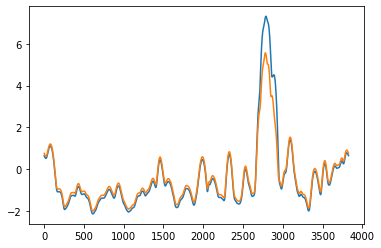

In [7]:

plt.plot(np.log10(od_dic['Urchin']['NDW']['Value']))
plt.plot(np.log10(od_dic['Cloudy']['NDW']['Value']))


In [8]:
import numpy as np 

np.array([14.154414,9.485295 ,0])/50

array([0.28308828, 0.1897059 , 0.        ])

In [9]:
Wizard['sightline']

{'ProjectionAxes': ['simx', 'simy', 'simz'],
 'x-axis': 0,
 'y-axis': 1,
 'z-axis': 2,
 'ProjectionStart': (0.28308827999999997, 0.1897059, 0),
 'x-position': 0.28308827999999997,
 'y-position': 0.1897059,
 'z-position': 0,
 'ProjectionLength': 1,
 'SightLength': 1,
 'ProjectionExtend': {'extend': False, 'extendfactor': 3},
 'nsight': 0,
 'Boxkms': {'Value': 3827.6916481695066,
  'Info': {'VarDescription': 'Extent of simulation volume in direction of projection in terms of Hubble velocity',
   'CGSConversionFactor': 100000.0,
   'aexp-scale-exponent': 0.0,
   'h-scale-exponent': 0.0}},
 'Box': {'Value': 33.885,
  'Info': {'VarDescription': 'Extent of simulation volume',
   'CGSConversionFactor': 3.0856775814913676e+24,
   'aexp-scale-exponent': 1.0,
   'h-scale-exponent': -1.0}},
 'short-LOS': False,
 'sightkms': {'Value': 3827.6916481695066,
  'Info': {'VarDescription': 'Extent of simulation volume in direction of projection in terms of Hubble velocity',
   'CGSConversionFactor': 1000

If we calculate the damping wings of this optical depth will have the problem that the damping-wing distorts our spectra beyond the velocity-space size of our sightline

In [10]:
dic = {'ReadIonFrac': True,
 'ReadHydrogen': True,
 'HI': 'HydrogenOneFraction',
 'ReadHelium': False,
 'He': '',
 'fname_urchin': '/madfs/data/dc-syke1/Urchin/Runs/ScienceRuns/Planck1/L0050N1504/RECAL/data/snapshot_012_z003p017/Combine/urchin_snap_012_z003p017.0.hdf5'}

In [11]:
dic

{'ReadIonFrac': True,
 'ReadHydrogen': True,
 'HI': 'HydrogenOneFraction',
 'ReadHelium': False,
 'He': '',
 'fname_urchin': '/madfs/data/dc-syke1/Urchin/Runs/ScienceRuns/Planck1/L0050N1504/RECAL/data/snapshot_012_z003p017/Combine/urchin_snap_012_z003p017.0.hdf5'}

In [12]:
vel_arr = np.arange(projected_LOS['npix']) * projected_LOS['pixel_kms']['Value']
from SpecWizard_Lines import Lines
lines = Lines( v_kms =vel_arr, box_kms=vel_arr.max())


In order to see the full effect we can make use of the optional parameter  ```extend``` in SpecWizard will insert the sightline in the middle of a velocity array ```extend_factor``` times bigger than the original. 


Now we can display other ions that contribute to the sightline. And this will illustrate the 

In [13]:
lambdazeros = {}
ions = Wizard['ionparams']['Ions']
for ion in Wizard['ionparams']['Ions']:
    lambdazeros[ion] = opticaldepth[ion]['lambda0']

In [14]:
vel_arr = np.arange(projected_LOS['npix']) * projected_LOS['pixel_kms']['Value']

In [15]:
snap_red = snapshot.header['Cosmo']['Redshift']

In [16]:
snap_red = snapshot.header['Cosmo']['Redshift']
lambdaz = np.array(list(lambdazeros.values()))  * ( 1 + snap_red)

In [17]:
 np.array(list(lambdazeros.values()))  * ( 1 + snap_red)

array([4882.74459215, 1220.1571331 , 3924.20535918, 6218.30026245,
       3351.63414744, 2408.25601453])

In [18]:
c_kms = constants['c'] /1e5

In [19]:
c_kms = constants['c'] /1e5
llinelambda_end   =  lambdaz[0] * np.exp(vel_arr/c_kms)

In [20]:
llinelambda_end

array([4882.74459215, 4882.76087795, 4882.7771638 , ..., 4945.43672219,
       4945.45321709, 4945.46971205])

In [21]:
np.array(list(lambdazeros.values())) 

array([1215.6701    ,  303.78581472,  977.02      , 1548.187     ,
        834.4654    ,  599.59      ])

In [22]:
from scipy.interpolate import interp1d


In [23]:
(c_kms)*np.log(lambdaz.max()/lambdaz.min())

488217.09982290666

In [58]:
from SpecWizard_Lines import Lines

In [59]:
from SpecWizard_Lines import Lines
lines = Lines( v_kms =vel_arr, box_kms=vel_arr.max())

In [26]:
ions

[('Hydrogen', 'H I'),
 ('Helium', 'He II'),
 ('Carbon', 'C III'),
 ('Carbon', 'C IV'),
 ('Oxygen', 'O II'),
 ('Oxygen', 'O III')]

('Hydrogen', 'H I') 4882.744592147201 4945.469712045608
('Helium', 'He II') 1220.157133102675 1235.831617201608
('Carbon', 'C III') 3924.2053591839244 3974.616812622766
('Carbon', 'C IV') 6218.300262449983 6298.18230873882
('Oxygen', 'O II') 3351.6341474417695 3394.6901889336777
('Oxygen', 'O III') 2408.256014526918 2439.193153344337


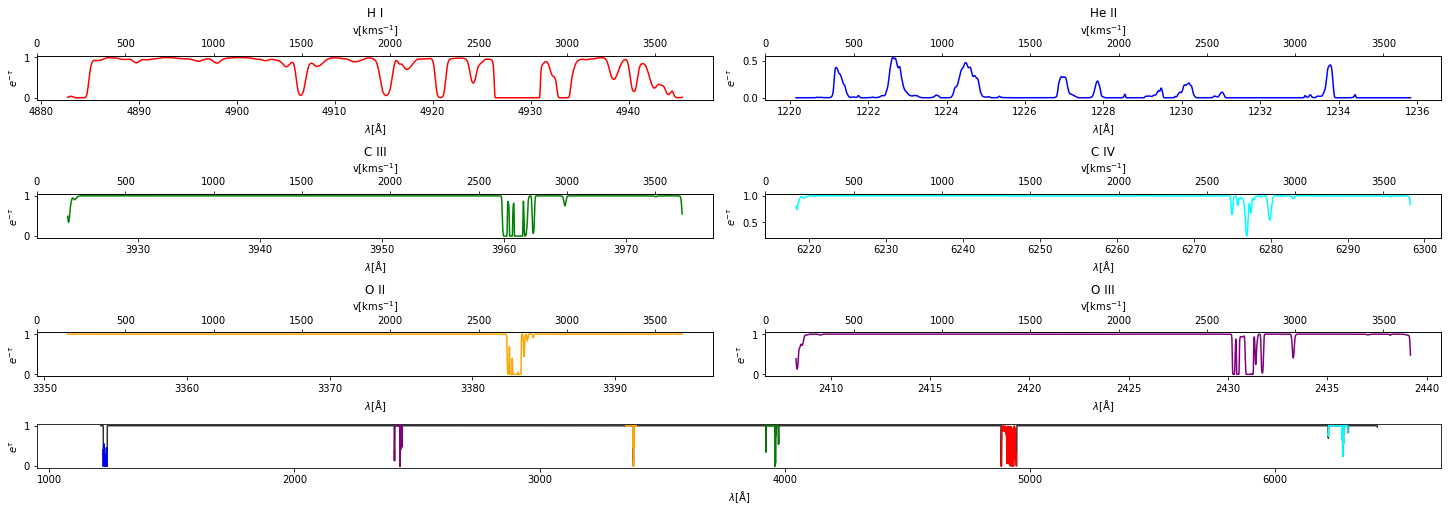

In [29]:
lambda_spectr = np.arange(lambdaz.min()-10,lambdaz.max()+200,0.012)
all_spectra   = np.zeros_like(lambda_spectr)
colours = ['red','blue','green','cyan','orange','purple']

fig = plt.figure(constrained_layout=True,figsize=(20, 7))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, :2])
ax4 = fig.add_subplot(gs[1, 2:])
ax5 = fig.add_subplot(gs[2, :2])
ax6 = fig.add_subplot(gs[2, 2:])
ax7 = fig.add_subplot(gs[-1, :])

axess = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

for axx,ion,cc in zip(axess,ions,colours):
    lambdaz_ion    = opticaldepth[ion]['lambda0'] * ( 1 + snap_red)
    
    
    od = opticaldepth[ion]['Optical depths']['Value']
    if ion == ('Hydrogen', 'H I'):
        od = opticaldepth['SimIons'][ion]['Optical depths']['Value']
    
    llinelambda_end   =  lambdaz_ion * np.exp(vel_arr/c_kms)
        
    axx.plot(llinelambda_end, np.exp(-od),c=cc)
    ax7.plot(llinelambda_end, np.exp(-od),c=cc)

    axx.set_title(ion[1])
    axx.set_xlabel(r'$\lambda [\mathrm{\AA}] $')
    axx.set_ylabel(r'$e^{-\tau}$')
    axx2 = axx.twiny()
    axx2.set_xlim(0,vel_arr.max())
    #axx2.plot(vel_arr,np.zeros_like(vel_arr))
    #axx2.cla()
    axx2.set_xlabel(r"$\mathrm{v[kms^{-1}]}$")
    print(ion,llinelambda_end.min(),llinelambda_end.max())
    all_spectra += Rebin(od,lambda_spectr,llinelambda_end)
ax7.plot(lambda_spectr,np.exp(-all_spectra),alpha=0.8,c='k',zorder=0)
ax7.set_xlabel(r'$\lambda [\mathrm{\AA}] $')
ax7.set_ylabel(r'$e^{\tau}$')

fig.show()
plt.savefig("shortspectra.pdf",dpi=300)

In [48]:
import importlib
import SpecWizard_Elements
SpecWizard_Elements = importlib.reload(SpecWizard_Elements)
from SpecWizard_Elements import Elements

In [49]:
from SpecWizard_Elements import Elements

In [50]:
elements = Elements(Wizard['ionparams'])

In [51]:
elementes = Elements('../../atom_dat.hdf5')

In [52]:
hyd_dat = elementes.ElementParameters(ElementNames=['Hydrogen'])

In [53]:
ly_lambda0 = hyd_dat['Hydrogen']['States']['H I']['Lines']['Lambda0']
ly_fvalues =  hyd_dat['Hydrogen']['States']['H I']['Lines']['f-value']

In [54]:
snap_red = snapshot.header['Cosmo']['Redshift']
lambdaz = np.array(ly_lambda0)  * ( 1 + snap_red)


In [55]:
c_kms = constants['c'] /1e5


In [60]:
lambda_spectr = np.arange(lambdaz.min()-200,lambdaz.max()+200,0.012)
all_spectra   = np.zeros_like(lambda_spectr)

In [61]:
lambda_spectr = np.arange((912*4)-10,lambdaz.max()+200,0.012)
all_spectra   = np.zeros_like(lambda_spectr)
colours = ['red','blue','green','cyan','orange','purple']

plt.figure(constrained_layout=True,figsize=(20, 7))


for i in range(len(ly_lambda0)):
    lambdaz_ion    = ly_lambda0[i] * ( 1 + snap_red)
    
    if i ==0:
        
        #dw  = lines.convolvelorentz(no_dw)

        llinelambda_end   =  lambdaz_ion * np.exp(vel_arr/c_kms)

        all_spectra += Rebin(no_dw,lambda_spectr,llinelambda_end)
        all_spectra = lines.convolvelorentz(all_spectra)
        llinelambda_end   = (912 * ( 1 + snap_red)) * np.exp(vel_arr/c_kms)
        dla = lines.convolveLymanLimit(no_dw)
        all_spectra += Rebin(dla,lambda_spectr,llinelambda_end)
    
    else:
        tau_line = no_dw * ly_lambda0[i] *  ly_fvalues[i] / (ly_lambda0[0] *  ly_fvalues[0])
        llinelambda_end   = lambdaz_ion * np.exp(vel_arr/c_kms)

        all_spectra += Rebin(tau_line,lambda_spectr,llinelambda_end)



ValueError: fp and xp are not of the same length.

<Figure size 1440x504 with 0 Axes>

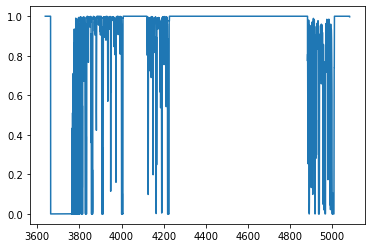

In [175]:
plt.plot(lambda_spectr,np.exp(-all_spectra))

In [62]:
def vel_from_wv(lambda_f,lambda_min,c_kms=1):
    '''
    Calculates velocity [km/s] from wavelength range
    '''
    return np.log(lambda_f/lambda_min) * c_kms


In [223]:
ly_lambda0[0] * ( 1 + snap_red)

4882.744592147201

In [63]:
        llinelambda_end   =  lambdaz_ion * np.exp(vel_arr/c_kms)
        vel_offset        = vel_from_wv(ly_lambda0[0] * ( 1 + snap_red),lambda_spectr.min(),c_kms=c_kms)

In [64]:
no_dw = opticaldepth['SimIons'][('Hydrogen','H I')]['Optical depths']['Value']

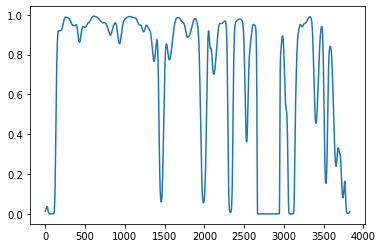

In [65]:
plt.plot(np.exp(-no_dw))

In [66]:

lambda_spectr = np.arange((912*4)-100,lambdaz.max()+700,0.012)
lambda_spectr = np.arange(2000,lambdaz.max()+700,0.012)

all_spectra   = np.zeros_like(lambda_spectr)

velocity_start = 0
pixkms = 1.0
velocity_end   = vel_from_wv(lambda_spectr.max(),lambda_spectr.min(),c_kms)
velocity_npix  = int((velocity_end-velocity_start) * pixkms)
velocity_shor  = int(len(no_dw)) * pixkms
velocity_array = velocity_start + (np.arange(velocity_npix) * pixkms)

all_spectra = np.zeros_like(velocity_array)
lines = Lines( v_kms =velocity_array, box_kms=velocity_array.max())
lines_short = Lines( v_kms =vel_arr, box_kms=vel_arr.max())

ly_series = {}

for i in range(len(ly_lambda0)):
    lambdaz_ion    = ly_lambda0[i] * ( 1 + snap_red)
    
    if i ==0:
        
        #dw  = lines.convolvelorentz(no_dw)
        dw = no_dw
        llinelambda_end   =  lambdaz_ion * np.exp(vel_arr/c_kms)
        vel_offset        = vel_from_wv(lambdaz_ion,lambda_spectr.min(),c_kms=c_kms)
        vel_arr_line      = vel_offset+vel_arr
        hi                =  Rebin(no_dw,velocity_array,vel_arr_line)
        all_spectra       +=    hi
        all_spectra = lines.convolvelorentz(all_spectra)

        lambdaz_ion = (912 * ( 1 + snap_red))
        vel_offset        = vel_from_wv(lambdaz_ion,lambda_spectr.min(),c_kms=c_kms)
        vel_arr_line      = vel_offset+vel_arr
        dum_arr           = np.zeros_like(all_spectra)
        dum_arr          += Rebin(no_dw ,velocity_array,vel_arr_line) 
        limit = lines.convolveLymanLimit(dum_arr)
        #limit = lines_short.convolveLymanLimit(no_dw)
        ly_series[ly_lambda0[i]] = hi
        ly_series["dla"]   = all_spectra.copy()
        ly_series["limit"] = limit

        #all_spectra += dla
    
    else:
          
        tau_line = no_dw * ly_lambda0[i] *  ly_fvalues[i] / (ly_lambda0[0] *  ly_fvalues[0])
        vel_offset        = vel_from_wv(lambdaz_ion,lambda_spectr.min(),c_kms=c_kms)
        vel_arr_line      = vel_offset+vel_arr
        tau_long           = Rebin(tau_line,velocity_array,vel_arr_line)

        ly_series[ly_lambda0[i]] = tau_long
        all_spectra += tau_long



In [68]:
kkeys = np.array(list(ly_series.keys()))[3:].astype(float)

In [73]:
ly_series.keys()

dict_keys([1215.6701, 'dla', 'limit', 1025.722, 972.5365, 949.74287, 937.80331, 930.748142, 926.225605, 923.150275, 920.963006, 919.351334, 918.1293, 917.180514, 916.429076, 915.823751, 915.328932, 914.919242, 914.576201, 914.286086, 914.038537, 913.825609, 913.641133, 913.480251, 913.339105, 913.214592, 913.104195, 913.005859, 912.917887, 912.838873, 912.767639, 912.703197, 912.644709, 912.591463, 912.542852, 912.498352, 912.457513, 912.419943, 912.385303, 912.353295, 912.32366])

(180000.0, 307745.0)

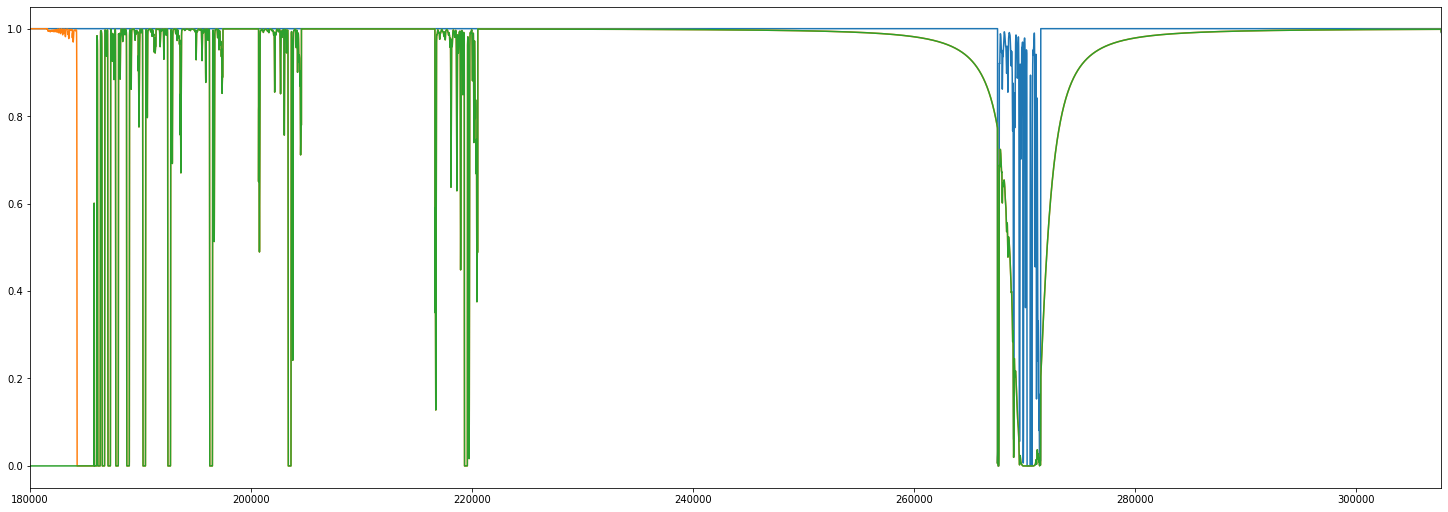

In [75]:
plt.figure(constrained_layout=True,figsize=(20, 7))

plt.plot(velocity_array,np.exp(-(ly_series[1215.6701]) ))
plt.plot(velocity_array,np.exp(-(all_spectra+0*ly_series['limit']) ))
plt.plot(velocity_array,np.exp(-(all_spectra+ly_series['limit']) ))
plt.xlim(180000,velocity_array.max())

In [345]:
lambdaz_ion    = ly_lambda0[0] * ( 1 + snap_red)
dw = no_dw
llinelambda_end   =  lambdaz_ion * np.exp(vel_arr/c_kms)
vel_offset        = vel_from_wv(lambdaz_ion,lambda_spectr.min(),c_kms=c_kms)
vel_arr_line      = vel_offset+vel_arr
hi                =  Rebin(no_dw,velocity_array,vel_arr_line)


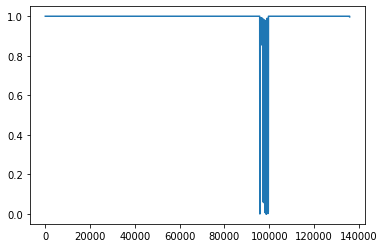

In [348]:
plt.plot(np.exp(-hi))

test_spectra = lines.convolvelorentz(hi)


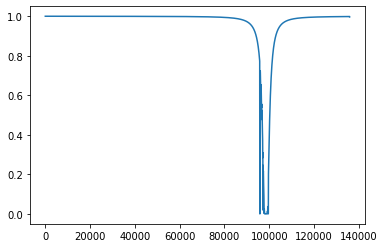

In [350]:
plt.plot(np.exp(-test_spectra))

/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/cosma/home/dp004/dc-aram1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


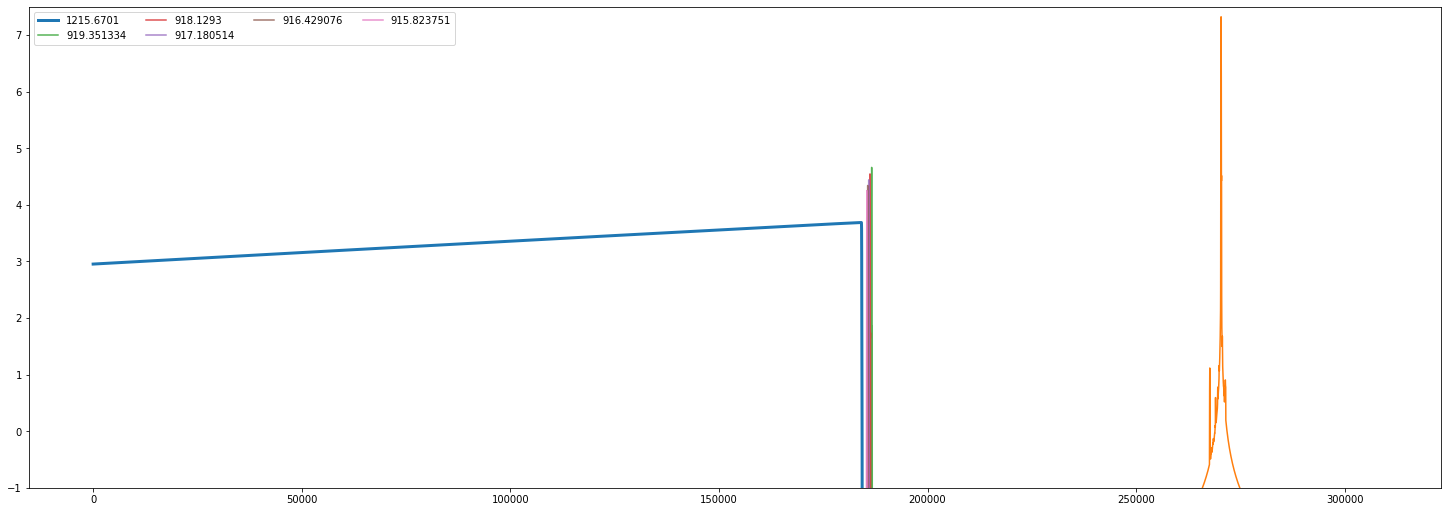

In [357]:
plt.figure(constrained_layout=True,figsize=(20, 7))

#plt.plot(velocity_array,np.exp(-(all_spectra+ly_series['limit'])))
mask_dla = ly_series['dla']>1e-3

plt.plot(velocity_array,np.log10(ly_series['limit']),label = '1215.6701',alpha=1,lw=3)
plt.plot(velocity_array[mask_dla],np.log10(ly_series['dla'][mask_dla]))
for i in kkeys[-30:-25]:
    plt.plot(velocity_array,np.log10(ly_series[i]),label =str(i),alpha=0.8)

plt.ylim(-1,7.5)
plt.legend(ncol=4)
#plt.xlim(0,10000)
#plt.xlim(85000,100000)

In [307]:
wavelength_space = rebin_to_spectrograph(ly_series,lambda_spectr,velocity_array)

In [358]:
redshift

NameError: name 'redshift' is not defined

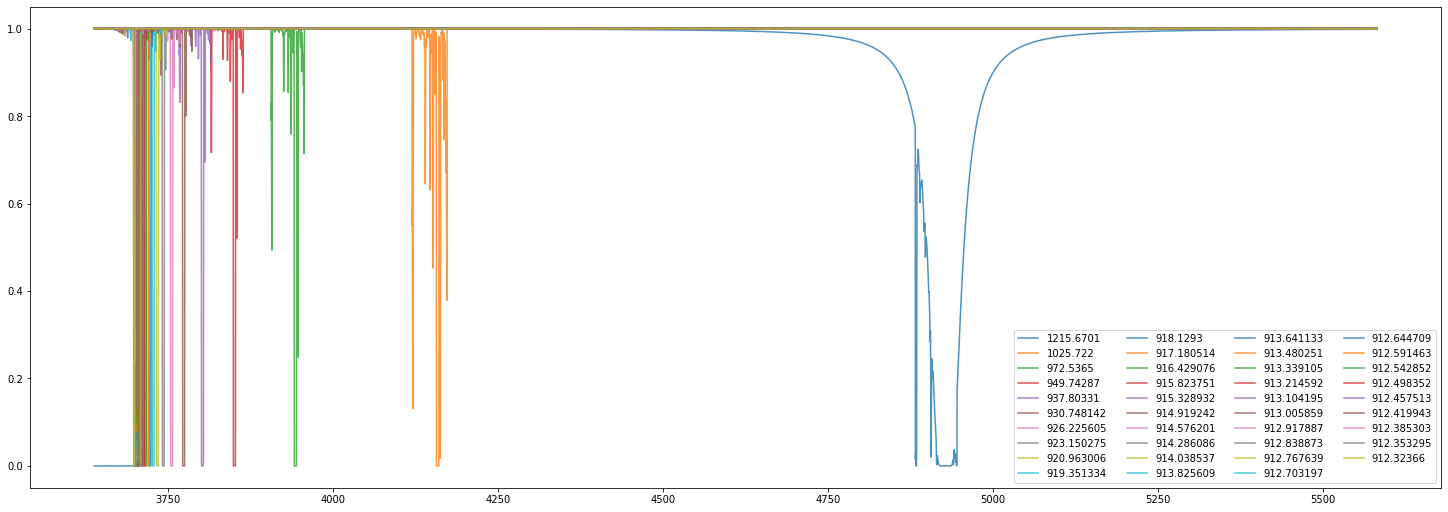

In [315]:
plt.figure(constrained_layout=True,figsize=(20, 7))

#plt.plot(velocity_array,np.exp(-(all_spectra+ly_series['limit'])))
wvkkeys = list(wavelength_space['lines'].keys())
plt.plot(wavelength_space['wavelength'],np.exp(-(wavelength_space['lines']['dla']+wavelength_space['lines']['limit'])),label = '1215.6701',alpha=0.8)
for i in wvkkeys[3:]:
    plt.plot(wavelength_space['wavelength'],np.exp(-wavelength_space['lines'][i]),label =str(i),alpha=0.8)

plt.legend(ncol=4)
#plt.xlim(85000,100000)

In [305]:
def rebin_to_spectrograph(long_spectra,lambda_spectr,velocity_array):
    dlambda    = 0.1
    npix       = int((lambda_spectr.max()-lambda_spectr.min())/dlambda)
    wavelength =  lambda_spectr.min() + (np.arange(npix) * dlambda) 
    c_kms = constants['c'] / 1e5
    wavelength_fine_array = lambda_spectr.min() * np.exp(velocity_array/c_kms)
    wavelength_tau = {}
    
    wavelength_tau['lines'] = {}
    for line in long_spectra.keys():
        wavelength_tau['lines'][line] = wave_rebin_total = Rebin(long_spectra[line],wavelength,wavelength_fine_array)        

    wavelength_tau['wavelength'] =  wavelength      

    return wavelength_tau

In [243]:
lambdaz_ion = (912 * ( 1 + snap_red))
vel_offset        = vel_from_wv(lambdaz_ion,lambda_spectr.min(),c_kms=c_kms)
vel_arr_line      = vel_offset+vel_arr
dum_arr           = np.zeros_like(all_spectra)
dum_arr          += Rebin(no_dw,velocity_array,vel_arr_line)
dla = lines.convolveLymanLimit(dum_arr)


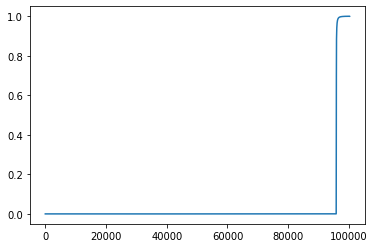

In [232]:
plt.plot(velocity_array,np.exp(-all_spectra))


In [217]:
np.exp(-wdla[20000])

5.732581342096433e-10

In [141]:
def contaminant(tau_strong,lambdazeros,fvalues,lambdastorn,fvaluestrong):

    tau_lines   = tau_ion * lambda0 * fvalue / (lambda0s[0]*fvalues[0])


3648

In [ ]:
gs = fig.add_gridspec(6, 6,hspace=0.0,wspace=0.5)

ax1 = fig.add_subplot(gs[0, :2])
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[0, :])
ax1.set_title('gs[0, :]')
ax2 = fig.add_subplot(gs[1, :-1])
ax2.set_title('gs[1, :-1]')
ax3 = fig.add_subplot(gs[1:, -1])
ax3.set_title('gs[1:, -1]')
ax4 = fig.add_subplot(gs[-1, 0])
ax4.set_title('gs[-1, 0]')
ax5 = fig.add_subplot(gs[-1, :])
ax5.set_title('gs[-1, -2]')
fig.show()

In [28]:
def Rebin(spectrum, wavelong,waveshort):
    ''' rebin the function y(x) to the new bins xnew
     Interpolation is performed such that the mean of the function is conserved
     Input: 
       -spectrum: dictionary, containing
          -L:       linear extent of the wavelength range
          -wave:    wavelength or Hubble velocity
          -flux:    flux
       -wave:       new wavelength or Hubble velocioty to rebin to 
       '''
    # determine pixel size
    L    = waveshort.max() #spectrum["L"]
    npix = len(spectrum) #spectrum["npix"]
    pix  = L/npix
    x0   = np.arange(npix) * pix
    vHubble = waveshort
    dx = vHubble[1:] -vHubble[0:-1]
    dx = np.concatenate([dx, [L - x0[-1]]])
    #
    xR = np.copy(vHubble) + dx  # right side of pixel

    # cumulative sum of the function y0(x0)
    f = np.cumsum(spectrum * dx)

    # new pixels
    dxnew = wavelong[1:] - wavelong[0:-1]  # size of pixels
    dxnew = np.concatenate([dxnew, [L - wavelong[-1]]])
    xnewR = np.copy(wavelong) + dxnew  # right side of pixels

    # interpolation function
    finterp = interp1d(xR,
                       f,
                       kind='linear',
                       bounds_error=False,
                       fill_value=(0, f[-1]))
    fnew = finterp(xnewR)

    # rebinned value
    fbinned = np.concatenate([[0], fnew])
    ynew = (fbinned[1:] - fbinned[0:-1]) / dxnew
    #
    newspectrum         = spectrum.copy()
    #newspectrum["wave"] = np.copy(wave)
    #newspectrum["flux"] = ynew
    return ynew

In [146]:
sd

NameError: name 'sd' is not defined

In [27]:
 import requests
from io import StringIO
from bs4 import BeautifulSoup

In [380]:
wavelength_range=None 
wavelength_type=None
wavelength_accuracy=None
element_spectrum=None
minimal_abundance=None
depl_factor=None
lower_level_energy_range=None
upper_level_energy_range=None
nmax=None
multiplet=None
transitions='all'
show_fine_structure=None
show_auto_ionizing_transitions=None

In [382]:
s = str(transitions)
if len(s.split(',')) > 1:
    _type = 'Sel'
    type2 = s.split(',')
else:
    _type = s
    type2 = ''

In [387]:
output_columns = ('spec', 'type', 'conf', 'term', 'angm', 'prob',
            'ener') 

In [432]:
        input_payload = {
            'wavl': None,
            'wave': 'Angstrom',
            'air': 'vacuum',
            'wacc': wavelength_accuracy,
            'elmion': None,
            'abun': minimal_abundance,
            'depl': depl_factor,
            'elo': lower_level_energy_range,
            'ehi': upper_level_energy_range,
            'ener': 'cm^-1',
            'nmax': nmax,
            'term': multiplet,
            'type': _type,
            'type2': type2,
            'hydr': show_fine_structure,
            'auto': show_auto_ionizing_transitions,
            'form': output_columns,
            'jval': 'usej',
            'tptype': 'as_a',
        }

In [433]:
response = requests.request("POST", url='https://linelist.pa.uky.edu/atomic/', data=input_payload,
                         timeout=1000)

In [442]:
import re
from mechanize import Browser

In [434]:
if 'ERROR: request form contains no information' in response.text:
    print("yes")
elif 'ERROR' in response.text:
    raise ValueError(f"The server returned an error.  The full error message is ")

In [579]:

payload= {
"wavl": s
"wave": "Angstrom",
"air": "Vacuum",
"wacc": "",
"elmion": 'C II',
"abun": "",
"depl": "",
"elo": "",
"ener": "cm^-1",
"ehi": "",
"nmax": "",
"term": "",
"type": "All",
"hydr": "Suppress",
"auto": "Suppress",
"form": [
    "spec",
    "type",
    "term",
    "angm",
    "prob",
    "ener"
],
"jval": "usej",
"tptype": "as_f",
"mode": "Plain"
}
respon = requests.post(url='https://linelist.pa.uky.edu/atomic/query.cgi',data=payload)
html_pre = BeautifulSoup(respon.text, features='html5lib').find('pre')
data = StringIO(html_pre.text.strip())
header = data.readline().strip().strip('|')
colnames = [colname.strip('-').replace('-', ' ')
            for colname in header.split('|') if colname.strip()]
indices = [i for i, c in enumerate(header) if c == '|']
result_data = []

for line in data:
    row = []
for start, end in zip([0] + indices, indices + [None]):
    # `value` will hold all cell values in the line, so
    # `u'1.010799'`, `u'Zn XXX'` etc.
    value = line[start:end].strip()
    if value:
        row.append(value)
    else:
        # maintain table dimensions when data missing
        row.append('None')
if row:
    result_data.append('\t'.join(row))


    bleh = ascii.read(result_data, data_start=0, delimiter='\t',
                          names=colnames, fast_reader=False)
bleh

LAMBDA VAC ANG,SPECTRUM,TT,TERM,J J,f_ik,LEVEL ENERGY CM 1
float64,str4,str2,str6,str7,float64,str23
5092.609,C II,E1,2Fo-2D,7/2-5/2,0.000471,168978.77 - 188615.07


In [580]:
table = get_ioninfo("C II")

In [ ]:
{
	"wavl": "",
	"wave": "Angstrom",
	"air": "Vacuum",
	"wacc": "",
	"elmion": "C+II",
	"abun": "",
	"depl": "",
	"elo": "",
	"ener": "cm^-1",
	"ehi": "",
	"nmax": "",
	"term": "",
	"type": "All",
	"hydr": "Suppress",
	"auto": "Suppress",
	"form": [
		"spec",
		"type",
		"term",
		"prob",
		"ener"
	],
	"jval": "usej",
	"tptype": "as_f",
	"mode": "Plain"
}

In [695]:
def get_iontable(ion="O VI"):
    payload= {
	"wavl": "",
	"wave": "Angstrom",
	"air": "Vacuum",
	"wacc": "",
	"elmion": ion,
	"abun": "",
	"depl": "",
	"elo": "",
	"ener": "cm^-1",
	"ehi": "",
	"nmax": "",
	"term": "",
	"type": "Sel",
    "type2": "E1",
	"hydr": "Suppress",
	"auto": "Suppress",
	"form": [
		"spec",
		"type",
		"term",
		"prob",
		"ener"
	],
	"jval": "usej",
	"tptype": "as_f",
	"mode": "Plain"
}

    respon = requests.post(url='https://linelist.pa.uky.edu/atomic/query.cgi',data=payload)
    html_pre = BeautifulSoup(respon.text, features='html5lib').find('pre')
    data = StringIO(html_pre.text.strip())
    header = data.readline().strip().strip('|')
    colnames = [colname.strip('-').replace('-', ' ')
                for colname in header.split('|') if colname.strip()]
    indices = [i for i, c in enumerate(header) if c == '|']
    result_data = []
    for line in data:
        row = []
        for start, end in zip([0] + indices, indices + [None]):
            # `value` will hold all cell values in the line, so
            # `u'1.010799'`, `u'Zn XXX'` etc.
            value = line[start:end].strip()
            if value:
                row.append(value)
            else:
                # maintain table dimensions when data missing
                row.append('None')
        if row:
            result_data.append('\t'.join(row))
    bleh = ascii.read(result_data, data_start=0, delimiter='\t',
                                  names=colnames, fast_reader=False)        
    return bleh        

In [697]:
tableo2

LAMBDA VAC ANG,SPECTRUM,TT,TERM,f_ik,LEVEL ENERGY CM 1
float64,str4,str2,str6,float64,str24
93.092,O VI,E1,2S-2Po,0.00322,0.00 - 1074210.00
93.915,O VI,E1,2S-2Po,0.00449,0.00 - 1064793.00
95.082,O VI,E1,2S-2Po,0.00656,0.00 - 1051724.00
96.8401,O VI,E1,2S-2Po,0.0101,0.00 - 1032630.00
99.688,O VI,E1,2S-2Po,0.0169,0.00 - 1003130.00
101.515,O VI,E1,2Po-2D,0.00304,96374.70 - 1081451.00
101.57,O VI,E1,2Po-2D,0.00304,96906.16 - 1081451.00
102.244,O VI,E1,2Po-2D,0.00389,96374.70 - 1074425.00
102.3,O VI,E1,2Po-2D,0.00389,96906.16 - 1074425.00


In [691]:
tableo2['f_ik'][tableo2['f_ik']=='None'] = '0'

In [692]:
sorted_indx = np.argsort(np.array(tableo2['f_ik'],dtype=float))[::-1]

In [693]:
tableo2[sorted_indx]

LAMBDA VAC ANG,SPECTRUM,TT,TERM,f_ik,LEVEL ENERGY CM 1
str9,str7,str2,str12,str8,str25
900.5,Ne IX,E1,3Po-3D,5.72E-01,9286646.00 - 9397700.00
906.221,S V,E1,3S-3Po,4.48E-01,311595.10 - 421943.40
904.1416,C II,E1,2Po-2P,4.19E-01,63.42 - 110665.56
901.64,Si VI,E1,4Do-4F,3.97E-01,1078935.00 - 1189844.00
902.19,Si VI,E1,4Do-4F,3.62E-01,1080700.00 - 1191541.00
900.84,Si VI,E1,4Do-4F,3.56E-01,1082215.00 - 1193223.00
903.11,S VII,E1,1Po-1D,3.43E-01,1388339.00 - 1499068.00
903.9616,C II,E1,2Po-2P,3.36E-01,0.00 - 110624.17
904.6,Si VII,E1,3D-3Fo,3.29E-01,1348486.00 - 1459027.00


In [1]:
payload = {
	"GET": {
		"scheme": "https",
		"host": "physics.nist.gov",
		"filename": "/cgi-bin/ASD/lines1.pl",
		"query": {
			"spectra": "H I",
			"limits_type": "0",
			"low_w": "",
			"upp_w": "",
			"unit": "0",
			"de": "0",
			"I_scale_type": "1",
			"format": "0",
			"line_out": "1",
			"en_unit": "0",
			"output": "0",
			"bibrefs": "1",
			"page_size": "15",
			"show_obs_wl": "1",
			"show_calc_wl": "1",
			"order_out": "0",
			"max_low_enrg": "",
			"show_av": "2",
			"max_upp_enrg": "",
			"tsb_value": "0",
			"min_str": "",
			"A_out": "0",
			"f_out": "on",
			"intens_out": "on",
			"max_str": "",
			"allowed_out": "1",
			"forbid_out": "1",
			"min_accur": "",
			"min_intens": "",
			"conf_out": "on",
			"term_out": "on",
			"enrg_out": "on",
			"submit": "Retrieve Data"
		},
		"remote": {
			"Address": "[2610:20:6b01:4::175]:443"
		}
	}
}

In [121]:
import requests
from bs4 import BeautifulSoup
import copy
import numpy as np
def query_line_from_nist(ion_to_q = "H I", wavelength_low_lim=300,wavelength_upper_lim=4200,acc='B+'):
    
    dwwl   = str(wavelength_low_lim)
    upwl   = str(wavelength_upper_lim)
    url   = 'https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra='+ion_to_q+'&limits_type=0&low_w='+dwwl+'&upp_w='+upwl+'&unit=0&de=0&I_scale_type=1&format=1&line_out=0&remove_js=on&no_spaces=on&en_unit=0&output=0&page_size=15&show_obs_wl=1&order_out=0&max_low_enrg=&show_av=3&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&f_out=on&max_str=&allowed_out=1&min_accur=&min_intens=&submit=Retrieve+Data'
    
    respond = requests.get(url=url)
    
    if 'No lines are available in ASD with the parameters selected' in respond.text:
        
        raise Exception("Line not in the ADS database")
        
    if 'Unrecognized token.' in respond.text:
        
        raise Exception("Unrecognized ion")
        
    table_post_pre = BeautifulSoup(respond.text, features='html5lib').find('pre')
    
    lines = table_post_pre.text.strip().split('\n')
    
    
    data = []

    # Iterate through the lines and extract data
    for line in lines:
        # Split the line using whitespace as a delimiter
        values = line.replace('|','').split()
        if len(values) == 4:
            # Check if the line contains data (5 values)
            observed, aki, fik, acc = values
            data.append([float(observed),
                float(aki),
                float(fik),
             acc])
    sorted_indx = np.argsort(np.vstack(data)[:,2].astype(float))
    return np.array(data)[sorted_indx][::-1]



In [122]:
data = query_line_from_nist('H I')

In [123]:
from SpecWizard

array([['1215.6701', '469860000.0', '0.41641', 'AAA'],
       ['1215.6699', '626470000.0', '0.2776', 'AAA'],
       ['1215.6699', '626480000.0', '0.1388', 'AAA'],
       ['1025.728', '55751000.0', '0.079142', 'AAA'],
       ['1025.728', '167250000.0', '0.052761', 'AAA'],
       ['972.517', '12785000.0', '0.029006', 'AAA'],
       ['1025.728', '167250000.0', '0.02638', 'AAA'],
       ['4102.892', '973200.0', '0.022105', 'AAA'],
       ['972.541', '68185000.0', '0.019337', 'AAA'],
       ['949.742', '4125000.0', '0.013945', 'AAA'],
       ['3971.198', '438890.0', '0.012711', 'AAA'],
       ['972.541', '68185000.0', '0.0096686', 'AAA'],
       ['949.742', '34375000.0', '0.0092969', 'AAA'],
       ['3890.166', '221480.0', '0.0080397', 'AAA'],
       ['937.814', '1644000.0', '0.0078035', 'AAA'],
       ['3836.485', '121560.0', '0.0054317', 'AAA'],
       ['937.801', '19728000.0', '0.0052022', 'AAA'],
       ['930.751', '756840.0', '0.0048164', 'AAA'],
       ['949.742', '34375000.0', '0.004


- AAA 	≤ 	0.3%
- AA 	≤ 	1%
- A+ 	≤ 	2%
- A 	≤ 	3%
- B+ 	≤ 	7%
- B 	≤ 	10%
- C+ 	≤ 	18%
- C 	≤ 	25%
- D+ 	≤ 	40%
- D 	≤ 	50%
- E 	> 	50%.

In [84]:
bad_accuracy = ['E','D','D+','C','C+','B']
good_accuracy = ['B+','A','A+','AA','AAA']

In [104]:
accuracy = np.array(['AAA','AA','A+','A','B+','B','C+','C','D+','D','E'])

array(['AAA', 'AA', 'A+', 'A', 'B+'], dtype='<U3')

In [96]:
res = [np.where(data[:,3]==i)[0] for i in good_accuracy]

In [101]:
data[np.concatenate(res)]

array([['395.558', '2800000000.0', '0.0394', 'B+'],
       ['599.598', '5410000000.0', '0.292', 'A'],
       ['525.795', '9600000000.0', '0.239', 'A'],
       ['597.818', '1490000000.0', '0.239', 'A'],
       ['508.182', '8040000000.0', '0.187', 'A'],
       ['507.391', '1610000000.0', '0.186', 'A'],
       ['507.683', '4820000000.0', '0.186', 'A'],
       ['702.332', '606000000.0', '0.134', 'A'],
       ['832.927', '341000000.0', '0.106', 'A'],
       ['703.85', '1370000000.0', '0.102', 'A'],
       ['835.292', '599000000.0', '0.0877', 'A'],
       ['833.742', '458000000.0', '0.0796', 'A'],
       ['702.899', '447000000.0', '0.0552', 'A'],
       ['702.822', '1830000000.0', '0.0452', 'A'],
       ['702.899', '466000000.0', '0.0345', 'A'],
       ['703.85', '754000000.0', '0.0336', 'A'],
       ['835.096', '144000000.0', '0.0151', 'A']], dtype='<U32')

In [741]:
'https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=He+II&limits_type=0&low_w=800&upp_w=4200&unit=0&de=0&I_scale_type=1&format=1&line_out=0&remove_js=on&no_spaces=on&en_unit=0&output=0&page_size=15&show_calc_wl=1&order_out=0&max_low_enrg=&show_av=3&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&f_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&submit=Retrieve+Data'

'https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=He+II&limits_type=0&low_w=800&upp_w=4200&unit=0&de=0&I_scale_type=1&format=1&line_out=0&remove_js=on&no_spaces=on&en_unit=0&output=0&page_size=15&show_calc_wl=1&order_out=0&max_low_enrg=&show_av=3&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&f_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&submit=Retrieve+Data'

In [131]:
atomfile = Atomfile()

In [132]:
atomfile.query_line_from_nist()

NameError: name 'np' is not defined

In [746]:
# Initialize lists to store extracted data
data = []

# Iterate through the lines and extract data
for line in lines:
    # Split the line using whitespace as a delimiter
    values = line.replace('|','').split()
    if len(values) == 4:
        # Check if the line contains data (5 values)
        observed, aki, fik, acc = values
        data.append([float(observed),
            float(aki),
            float(fik),
             acc])

array([['1215.6701', '469860000.0', '0.41641', 'AAA'],
       ['1215.6699', '626470000.0', '0.2776', 'AAA'],
       ['1215.6699', '626480000.0', '0.1388', 'AAA'],
       ['1025.728', '55751000.0', '0.079142', 'AAA'],
       ['1025.728', '167250000.0', '0.052761', 'AAA'],
       ['972.517', '12785000.0', '0.029006', 'AAA'],
       ['1025.728', '167250000.0', '0.02638', 'AAA'],
       ['4102.892', '973200.0', '0.022105', 'AAA'],
       ['972.541', '68185000.0', '0.019337', 'AAA'],
       ['949.742', '4125000.0', '0.013945', 'AAA'],
       ['3971.198', '438890.0', '0.012711', 'AAA'],
       ['972.541', '68185000.0', '0.0096686', 'AAA'],
       ['949.742', '34375000.0', '0.0092969', 'AAA'],
       ['3890.166', '221480.0', '0.0080397', 'AAA'],
       ['937.814', '1644000.0', '0.0078035', 'AAA'],
       ['3836.485', '121560.0', '0.0054317', 'AAA'],
       ['937.801', '19728000.0', '0.0052022', 'AAA'],
       ['930.751', '756840.0', '0.0048164', 'AAA'],
       ['949.742', '34375000.0', '0.004

In [591]:
payload= {
	"wavl": "",
	"wave": "Angstrom",
	"air": "Vacuum",
	"wacc": "",
	"elmion": "C II",
	"abun": "",
	"depl": "",
	"elo": "",
	"ener": "cm^-1",
	"ehi": "",
	"nmax": "",
	"term": "",
	"type": "All",
	"hydr": "Suppress",
	"auto": "Suppress",
	"form": [
		"spec",
		"type",
		"term",
		"angm",
		"prob",
		"ener"
	],
	"jval": "usej",
	"tptype": "as_f",
	"mode": "Plain"
}

bleh = ascii.read(result_data, data_start=0, delimiter='\t',
                              names=colnames, fast_reader=False)

In [592]:
from astropy.io import ascii

In [593]:
respon = requests.post(url='https://linelist.pa.uky.edu/atomic/query.cgi',data=payload)

In [594]:
html_pre = BeautifulSoup(respon.text, features='html5lib').find('pre')


In [595]:
data = StringIO(html_pre.text.strip())

In [596]:
header = data.readline().strip().strip('|')


In [597]:
colnames = [colname.strip('-').replace('-', ' ')
            for colname in header.split('|') if colname.strip()]

In [598]:
indices = [i for i, c in enumerate(header) if c == '|']
result_data = []

In [599]:
for line in data:
    row = []
    for start, end in zip([0] + indices, indices + [None]):
        # `value` will hold all cell values in the line, so
        # `u'1.010799'`, `u'Zn XXX'` etc.
        value = line[start:end].strip()
        if value:
            row.append(value)
        else:
            # maintain table dimensions when data missing
            row.append('None')
    if row:
        result_data.append('\t'.join(row))


In [600]:
bleh = ascii.read(result_data, data_start=0, delimiter='\t',
                              names=colnames, fast_reader=False)

In [601]:
bleh

LAMBDA VAC ANG,SPECTRUM,TT,TERM,J J,f_ik,LEVEL ENERGY CM 1
float64,str5,str2,str6,str7,str8,str23
530.27541,C II,E1,2Po-2D,1/2-3/2,3.62E-02,0.00 - 188581.25
530.35866,C II,E1,2Po-2D,3/2-5/2,3.26E-02,63.42 - 188615.07
530.4538,C II,E1,2Po-2D,3/2-3/2,3.62E-03,63.42 - 188581.25
533.7518,C II,E1,2Po-2D,1/2-*,2.99E-02,0.00 - 187353.00
533.9325,C II,E1,2Po-2D,3/2-*,2.99E-02,63.42 - 187353.00
536.35497,C II],E1,2Po-4P,1/2-3/2,None,0.00 - 186443.69
536.40198,C II],E1,2Po-4P,1/2-1/2,None,0.00 - 186427.35
536.4732,C II],E1,2Po-4P,3/2-5/2,None,63.42 - 186466.02
536.53748,C II],E1,2Po-4P,3/2-3/2,None,63.42 - 186443.69


In [496]:


        indices = [i for i, c in enumerate(header) if c == '|']
        result_data = []
        for line in data:
            row = []
            for start, end in zip([0] + indices, indices + [None]):
                # `value` will hold all cell values in the line, so
                # `u'1.010799'`, `u'Zn XXX'` etc.
                value = line[start:end].strip()
                if value:
                    row.append(value)
                else:
                    # maintain table dimensions when data missing
                    row.append('None')
            if row:
                result_data.append('\t'.join(row))
        if result_data:
            return ascii.read(result_data, data_start=0, delimiter='\t',
                              names=colnames, fast_reader=False)
        else:
            # return an empty table if the query yielded no results
            return Table()

'BDA-VAC-ANG-|-SPECTRUM--|TT|--------TERM---------|---J-J---|--f_ik--|----LEVEL ENERGY--CM-1----|\n    530.27541     C II       E1        2Po-2D          1/2-3/2  3.62E-02         0.00 -   188581.25\n    530.35866     C II       E1        2Po-2D          3/2-5/2  3.26E-02        63.42 -   188615.07\n    530.45380     C II       E1        2Po-2D          3/2-3/2  3.62E-03        63.42 -   188581.25\n    533.7518      C II       E1        2Po-2D          1/2-*    2.99E-02         0.00 -   187353.00\n    533.9325      C II       E1        2Po-2D          3/2-*    2.99E-02        63.42 -   187353.00\n    536.35497     C II]      E1        2Po-4P          1/2-3/2                   0.00 -   186443.69\n    536.40198     C II]      E1        2Po-4P          1/2-1/2                   0.00 -   186427.35\n    536.47320     C II]      E1        2Po-4P          3/2-5/2                  63.42 -   186466.02\n    536.53748     C II]      E1        2Po-4P          3/2-3/2                  63.42 -   186

In [436]:
html_pre = BeautifulSoup(response.text, features='html5lib').find('pre')
if html_pre is None:
    raise ValueError("Data format not recognized.  The <pre> tag was missing from the response.")

data = StringIO(html_pre.text.strip())

ValueError: Data format not recognized.  The <pre> tag was missing from the response.

In [415]:
html_pre

In [284]:
import h5py 

In [281]:
zqsr = 3
l_min = 945
l_max = 8000

In [387]:
atomfile = h5py.File("../../atom_dat.hdf5",'r')

In [397]:
atomfile.close()

In [334]:
atomfile = h5py.File("../../atom_dat.hdf5",'r')
zqsr = 3
l_min = 945
l_max = 8000
lambda0z = {}
for element in atomfile.keys():
    
    for ion in atomfile[element].keys():
        lambda0s = atomfile[element][ion]['lambda0'][...]
        fvalues  = atomfile[element][ion]['f-value'][...]
        for lambda0,fvalue in zip(lambda0s,fvalues):
            lambda0z[lambda0] = {}
            lambda0z[lambda0]['fvalue'] = fvalue
            lambda0z[lambda0]['ion']    = ion
            lambda0z[lambda0]['element'] = element

In [335]:
all_lambda0  = np.array(list(lambda0z.keys()))

In [336]:
all_lambda0

array([4227.918, 2276.169, 2399.289, ...,  491.46 ,  445.7  ,  417.66 ])

In [338]:
contamintants = all_lambda0[mask]

In [340]:
inv_map = {v: k for k, v in lambda0z.items()}

TypeError: unhashable type: 'dict'

In [344]:
mask1 = [lambda0z[cont]['ion']=='Ca I' for cont in contamintants]


array([357.9692, 403.7201, 296.957 , 409.953 , 273.6997, 301.7472,
       304.3376, 262.51  , 274.466 , 304.9133, 256.38  , 262.63  ,
       264.7   , 254.48  , 251.98  , 252.57  , 250.06  , 248.34  ,
       250.24  , 439.692 , 309.5941, 265.49  , 252.11  , 254.71  ,
       490.552 , 250.34  , 264.47  , 258.73  , 258.3   , 258.18  ,
       655.998 , 669.696 , 466.24  , 646.534 , 651.531 , 656.745 ,
       643.104 , 637.917 , 647.855 , 641.904 , 633.844 , 629.602 ,
       624.385 , 639.15  , 630.535 , 630.785 , 640.414 , 640.672 ,
       582.845 , 596.935 , 597.858 , 557.765 , 574.01  , 378.39  ,
       432.    ])

In [349]:
BI     = Build_Input()
Wizard = BI.read_from_yml("Wizard.yml")

Warning! SightLength NOT found. Setting default value : 1


In [351]:
Wizard['ionparams']

{'table_type': 'ploeckinger',
 'iondir': '/cosma7/data/dp004/dc-aram1/pyspecwizard_main/sylviatables//',
 'fname': 'UVB_dust1_CR1_G1_shield1.hdf5',
 'ions-available': [],
 'Ions': [('Hydrogen', 'H I'),
  ('Helium', 'He II'),
  ('Carbon', 'C III'),
  ('Carbon', 'C IV'),
  ('Oxygen', 'O II'),
  ('Oxygen', 'O III')],
 'SFR_properties': {'modify_particle': True,
  'ignore_particle': False,
  'Temperature [K]': 10000.0},
 'atomfile': '../../atom_dat.hdf5',
 'IonizationBalance': <SpecWizard_IonTables.IonTables at 0x7fb868f1f278>,
 'transitionparams': {'H I': {'Mass': 1.008,
   'lambda0': 1215.6701,
   'f-value': 0.41641},
  'He II': {'Mass': 4.002602,
   'lambda0': 303.785814724,
   'f-value': 0.416289999999},
  'C III': {'Mass': 12.011, 'lambda0': 977.02, 'f-value': 0.7586},
  'C IV': {'Mass': 12.011, 'lambda0': 1548.187, 'f-value': 0.19},
  'O II': {'Mass': 15.999, 'lambda0': 834.4654, 'f-value': 0.135},
  'O III': {'Mass': 15.999, 'lambda0': 599.59, 'f-value': 0.292}}}

In [352]:
sylvtable = h5py.File('/cosma7/data/dp004/dc-aram1/pyspecwizard_main/sylviatables/UVB_dust1_CR1_G1_shield1.hdf5','r')

In [353]:
sylvtable.keys()

<KeysViewHDF5 ['AbundanceHe', 'ElementMasses', 'ElementNames', 'ElementNamesShort', 'IdentifierCooling', 'IdentifierHeating', 'JMW', 'NumberOfBins', 'NumberOfIons', 'SolarMetallicity', 'TableBins', 'Tdep', 'ThermEq', 'TotalAbundances', 'TotalExactMetallicity', 'TotalMassFractions', 'Udep']>

In [364]:
sylvtable['Tdep']['IonFractions'].keys()

<KeysViewHDF5 ['00hydrogen', '01helium', '02carbon', '03nitrogen', '04oxygen', '05neon', '06magnesium', '07silicon', '08sulphur', '09calcium', '10iron']>

In [369]:
sylvtable['Tdep']['IonFractions']['02carbon']

<HDF5 dataset "02carbon": shape (46, 86, 11, 71, 7), type "<f4">

In [371]:
sylvtable['NumberOfIons'][...]

array([ 2,  3,  7,  8,  9, 11, 13, 15, 17, 21, 27], dtype=int8)

In [ ]:
['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 
                    'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII',
                'XVIII', 'XIX', 'XX', 'XXI', 'XXII', 'XXIII', 'XXIV', 'XXV', 'XXVI']

In [1]:
import pyread_eagle as read_eagle

In [2]:
fname = '/madfs/data/dc-syke1/Urchin/Runs/ScienceRuns/Planck1/L0050N1504/RECAL/data/snapshot_010_z003p984/Combine/urchin_snap_010_z003p984.0.hdf5'
snap = read_eagle.EagleSnapshot(fname, verbose=False)

In [3]:
snap.select_region(15,17, 20, 23, 40, 50)

In [ ]:
data = snap.read_dataset(0, "HydrogenOneFraction")